In [1]:
import operator
import random
import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from itertools import product
from collections import namedtuple
from abc import ABC, abstractmethod
from scipy.stats import beta

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize

from tqdm import tqdm

%matplotlib inline
sns.set()

# Визуальный анализ получившихся синтетических данных 

In [218]:
raw_data = []
with open("data_v8.pckl","rb") as fileOpener:
    while True:
        try:
            raw_data.append(pickle.load(fileOpener))
        except EOFError:
            break

In [219]:
df = pd.DataFrame(raw_data)

In [238]:
targets_df = df[['taxi', 'car', 'bike', 'pedestrian', 'ot']]

In [243]:
from collections import Counter

In [244]:
Counter(targets_df.values.argmax(1))

Counter({1: 13330, 0: 2551, 4: 12724, 3: 1294, 2: 101})

In [220]:
df.head(20)

,taxi,car,bike,pedestrian,ot,sex,age,has_vehicle,income,has_spouse,...,снег,туман,мгла,гроза,метель,гололёд,изморозь,ветер,облачный день,температура
0,0.948945,1.000000,0.000000,0.000000,0.851626,0,25-33,1,high-middle,1,...,0,0,0,0,0,0,0,7.38,1,2.10
1,1.000000,1.000000,0.000000,0.000000,0.609046,0,33-45,1,rich,1,...,0,0,0,0,0,0,0,8.71,1,19.36
2,0.579785,1.000000,0.000000,0.000000,0.515093,0,45-60,1,middle,1,...,1,0,0,0,0,0,0,12.98,1,6.69
3,0.988840,1.000000,0.000000,0.000000,0.764512,0,33-45,1,high-middle,1,...,1,0,0,0,0,0,0,0.00,1,-7.06
4,0.745931,1.000000,0.000000,0.070824,0.776762,1,16-25,1,high-middle,1,...,0,0,0,0,0,0,0,0.00,1,5.62
5,0.683239,1.000000,0.000000,0.000000,0.539330,0,45-60,1,middle,1,...,0,0,0,0,0,0,0,9.34,1,2.10
6,0.069264,0.055770,0.118080,0.574290,0.674279,0,16-25,0,powerty,0,...,0,0,0,0,0,0,1,4.58,1,1.61
7,0.000000,0.608053,0.533516,0.469827,0.475833,1,45-60,1,middle,1,...,0,0,0,0,0,0,0,0.09,1,-1.30
8,0.536096,0.542638,0.000000,0.175012,1.000000,1,16-25,0,powerty,0,...,1,0,0,0,0,0,0,0.00,1,-10.96
9,0.999276,1.000000,0.000000,0.074340,0.695471,0,25-33,1,high-middle,1,...,0,0,0,0,0,0,0,0.00,1,-1.36


In [221]:
df.sex.value_counts()

1    15031
0    14969
Name: sex, dtype: int64

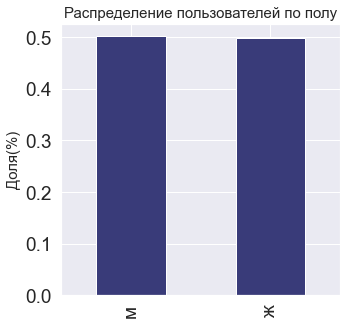

In [222]:
plt.figure(figsize=(5,5))
ax = df.sex.value_counts(normalize=True).plot(kind='bar',  xticks=[0,1], fontsize = 19, colormap = 'tab20b', title = 'Распределение пользователей по социальным классам', ylabel='Доля(%)')
ax.set_xticklabels(['м', 'ж'])
plt.ylabel('Доля(%)', fontsize=15)
plt.title('Распределение пользователей по полу', fontsize=15);

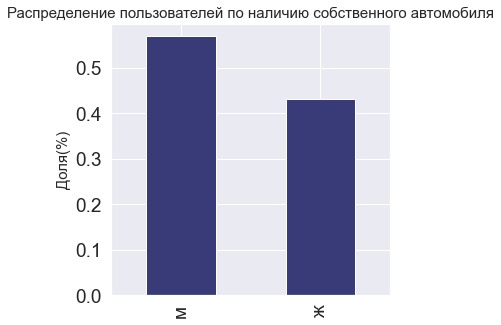

In [223]:
plt.figure(figsize=(5,5))
ax = df.has_vehicle.value_counts(normalize=True).plot(kind='bar',  xticks=[0,1], fontsize = 19, colormap = 'tab20b', title = 'Распределение пользователей по социальным классам', ylabel='Доля(%)')
ax.set_xticklabels(['м', 'ж'])
plt.ylabel('Доля(%)', fontsize=15)
plt.title('Распределение пользователей по наличию собственного автомобиля', fontsize=15);

In [65]:
df.columns

Index(['taxi', 'car', 'bike', 'pedestrian', 'ot', 'sex', 'age', 'has_vehicle',
       'income', 'has_spouse', 'балл_пробок', 'дождь', 'снег', 'туман', 'мгла',
       'гроза', 'метель', 'гололёд', 'изморозь', 'ветер', 'облачный день',
       'температура'],
      dtype='object')

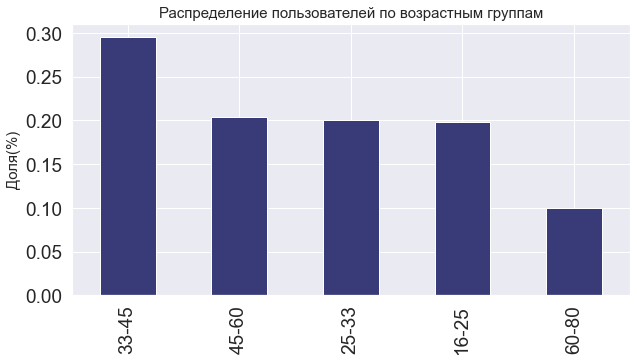

In [224]:
plt.figure(figsize=(10,5))
ax = df.age.value_counts(normalize=True).plot(kind='bar', fontsize = 19, colormap = 'tab20b', title = 'Распределение пользователей по социальным классам', ylabel='Доля(%)')
plt.ylabel('Доля(%)', fontsize=15)
plt.title('Распределение пользователей по возрастным группам', fontsize=15);

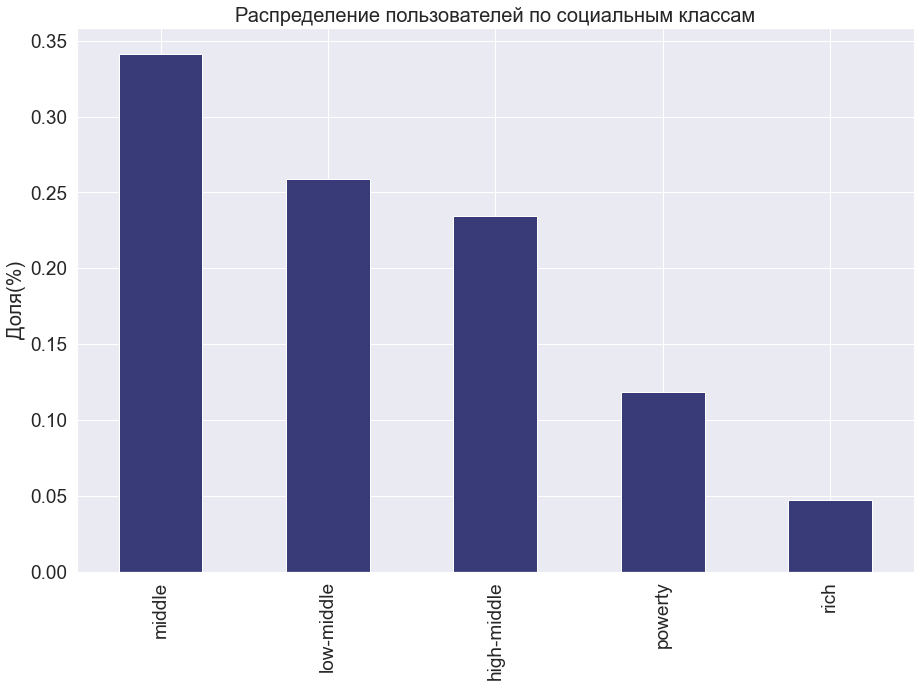

In [225]:
plt.figure(figsize=(15,10))
df.income.value_counts(normalize=True).plot(kind='bar', fontsize = 19, colormap = 'tab20b', title = 'Распределение пользователей по социальным классам', ylabel='Доля(%)')
plt.ylabel('Доля(%)', fontsize=20)
plt.title('Распределение пользователей по социальным классам', fontsize=20);

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   taxi           30000 non-null  float64
 1   car            30000 non-null  float64
 2   bike           30000 non-null  float64
 3   pedestrian     30000 non-null  float64
 4   ot             30000 non-null  float64
 5   sex            30000 non-null  int64  
 6   age            30000 non-null  object 
 7   has_vehicle    30000 non-null  int64  
 8   income         30000 non-null  object 
 9   has_spouse     30000 non-null  int64  
 10  балл_пробок    30000 non-null  int64  
 11  дождь          30000 non-null  int64  
 12  снег           30000 non-null  int64  
 13  туман          30000 non-null  int64  
 14  мгла           30000 non-null  int64  
 15  гроза          30000 non-null  int64  
 16  метель         30000 non-null  int64  
 17  гололёд        30000 non-null  int64  
 18  изморо

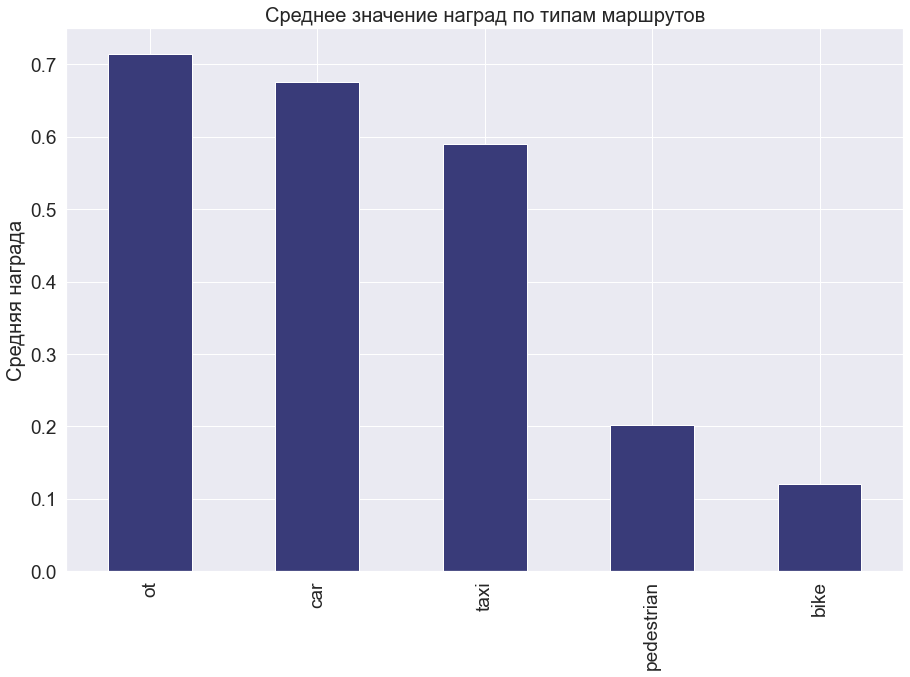

In [226]:
plt.figure(figsize=(15,10))
df[targets].describe().loc['mean', :].sort_values(ascending=False).plot(kind='bar', fontsize = 19, colormap = 'tab20b',  ylabel='Значение награды')
plt.ylabel('Средняя награда', fontsize=20)
plt.title('Среднее значение наград по типам маршрутов', fontsize=20);



<Figure size 1080x1440 with 0 Axes>

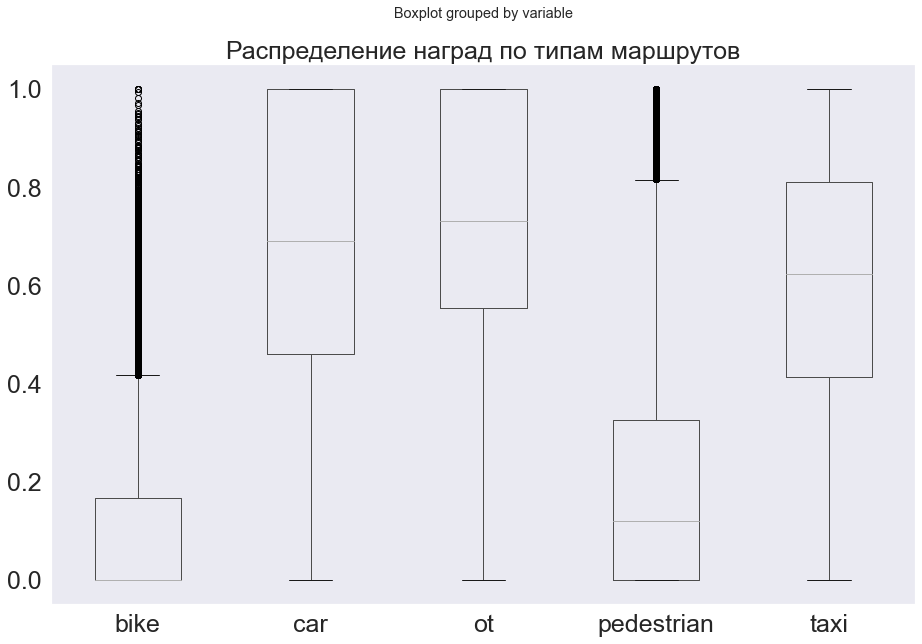

In [227]:
plt.figure(figsize=(15,20))
ax = pd.melt(df, value_vars=targets).boxplot(by='variable', fontsize =25, figsize=(15,10) ,grid=False)
x_axis = ax.axes.get_xaxis()
x_label = x_axis.get_label()
plt.title('Распределение наград по типам маршрутов', fontsize=25);
##print isinstance(x_label, matplotlib.artist.Artist)
x_label.set_visible(False);

In [228]:
df.groupby('балл_пробок')[targets].mean()

,taxi,car,bike,pedestrian,ot
балл_пробок,,,,,
2,0.640782,0.739728,0.033540,0.150870,0.734565
3,0.616867,0.731660,0.050244,0.172660,0.701845
4,0.616125,0.731735,0.048904,0.168881,0.701960
5,0.618189,0.734090,0.047643,0.170376,0.703513
6,0.616165,0.732577,0.048491,0.170140,0.697278
7,0.478606,0.438970,0.423259,0.337306,0.772728
8,0.491676,0.500463,0.375826,0.304486,0.762843


<Figure size 1080x720 with 0 Axes>

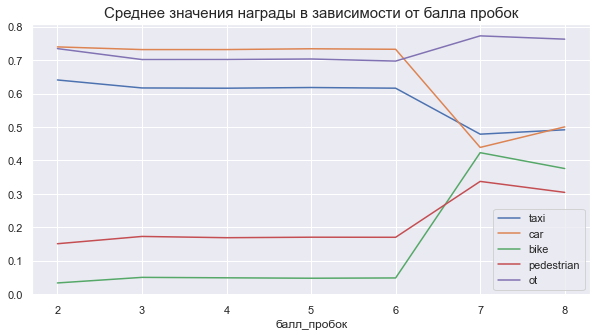

In [229]:
plt.figure(figsize=(15,10))
df.groupby('балл_пробок')[targets].mean().plot(figsize=(10,5))
plt.title('Среднее значения награды в зависимости от балла пробок', fontsize=15);

In [230]:
df_wind = df.copy()
df_wind['bins'] = pd.cut(df['ветер'], 7)

In [231]:
df_wind['bins_mean'] = df_wind.groupby('bins')['ветер'].transform('mean')

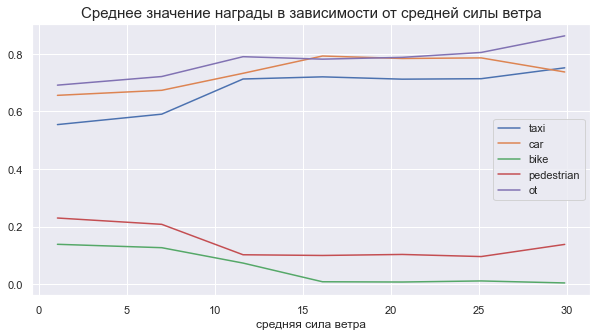

In [232]:
df_wind.groupby('bins_mean')[targets].mean().plot(xlabel='средняя сила ветра', figsize=(10 ,5))
plt.title('Среднее значение награды в зависимости от средней силы ветра', fontsize=15);

In [233]:
df_temp = df.copy()
df_temp['bins'] = pd.cut(df['температура'], 7)
df_temp['bins_mean'] = df_temp.groupby('bins')['температура'].transform('mean')

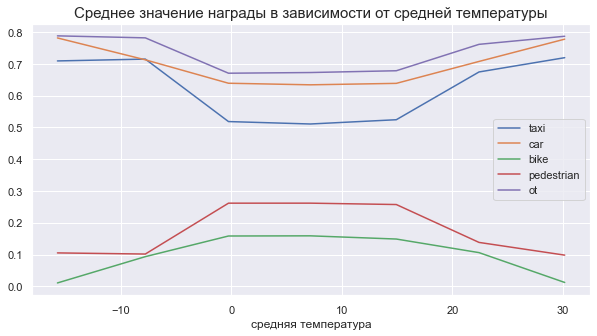

In [234]:
df_temp.groupby('bins_mean')[targets].mean().plot(xlabel='средняя температура', figsize=(10 ,5))
plt.title('Среднее значение награды в зависимости от средней температуры', fontsize=15);

In [29]:
df.select_dtypes([np.float64]).head()

,taxi,car,bike,pedestrian,ot,ветер,температура
0,1.000000,1.000000,0.034954,0.000000,0.539752,6.51,-5.20
1,0.448599,0.962518,0.338625,0.262977,0.532985,1.70,13.26
2,0.305673,0.994479,0.118051,0.193461,0.170391,0.00,2.10
3,0.533262,0.475670,0.000000,0.000000,1.000000,8.10,14.88
4,0.715424,0.481781,0.000000,0.209730,1.000000,0.00,-0.46


In [9]:
numeric_data = df.select_dtypes([np.number])
numeric_features = numeric_data.columns
cat_data = df.select_dtypes([np.object])
cat_features = cat_data.columns

In [16]:
numeric_features

Index(['taxi', 'car', 'bike', 'pedestrian', 'ot', 'sex', 'has_vehicle',
       'has_spouse', 'балл_пробок', 'дождь', 'снег', 'туман', 'мгла', 'гроза',
       'метель', 'гололёд', 'изморозь', 'ветер', 'облачный день',
       'температура'],
      dtype='object')

array(['sex', 'has_vehicle', 'has_spouse', 'балл_пробок', 'дождь', 'снег',
       'туман', 'мгла', 'гроза', 'метель', 'гололёд', 'изморозь', 'ветер',
       'облачный день', 'температура'], dtype=object)

In [15]:
targets = ['taxi', 'car', 'bike', 'pedestrian', 'ot']

<Figure size 1440x1440 with 0 Axes>

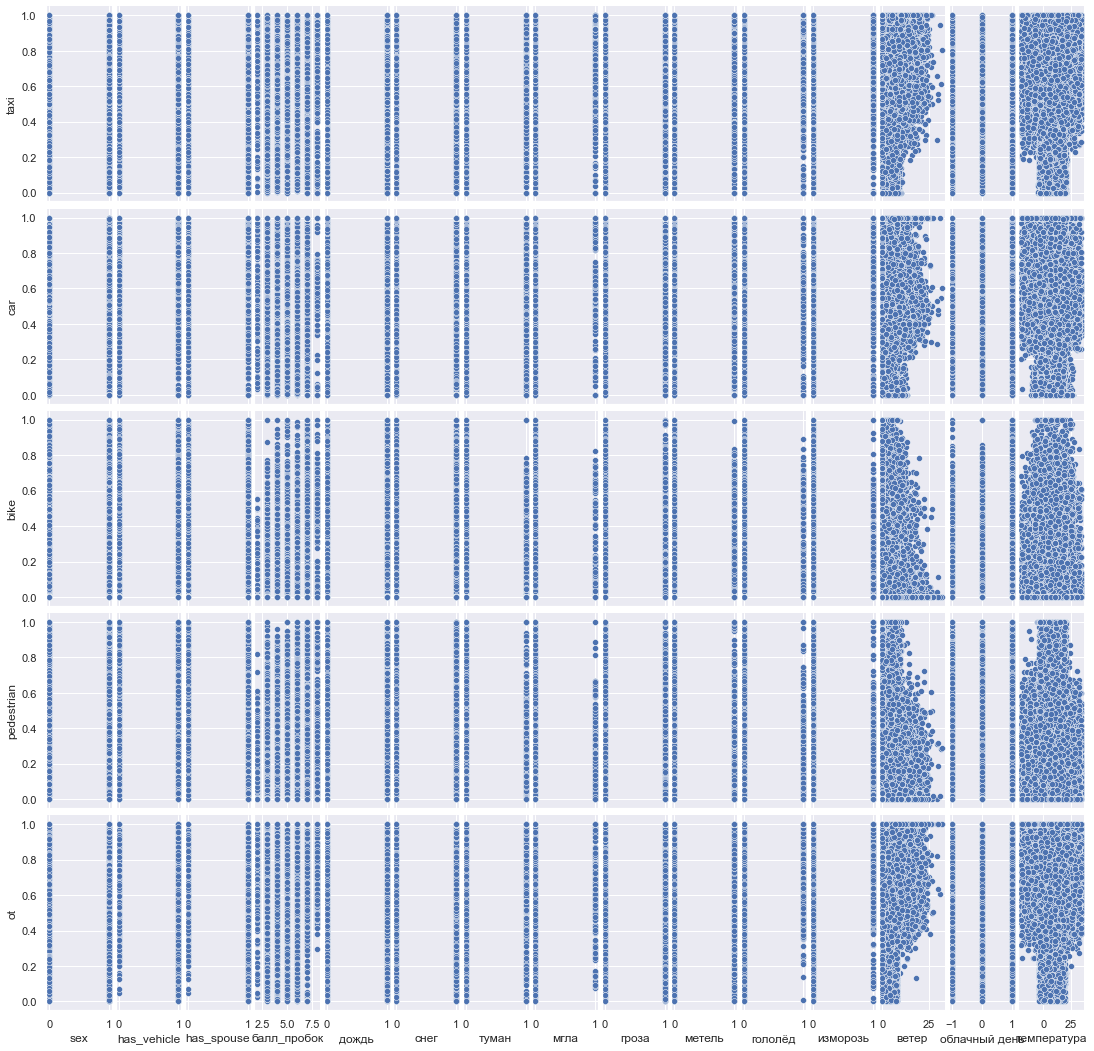

In [166]:


g=sns.pairplot(
    df[numeric_features],
    y_vars=targets,
    x_vars=np.array(numeric_features)[~np.isin(numeric_features, targets)],
)
g.fig.set_size_inches(15,15)

<Figure size 1080x720 with 0 Axes>

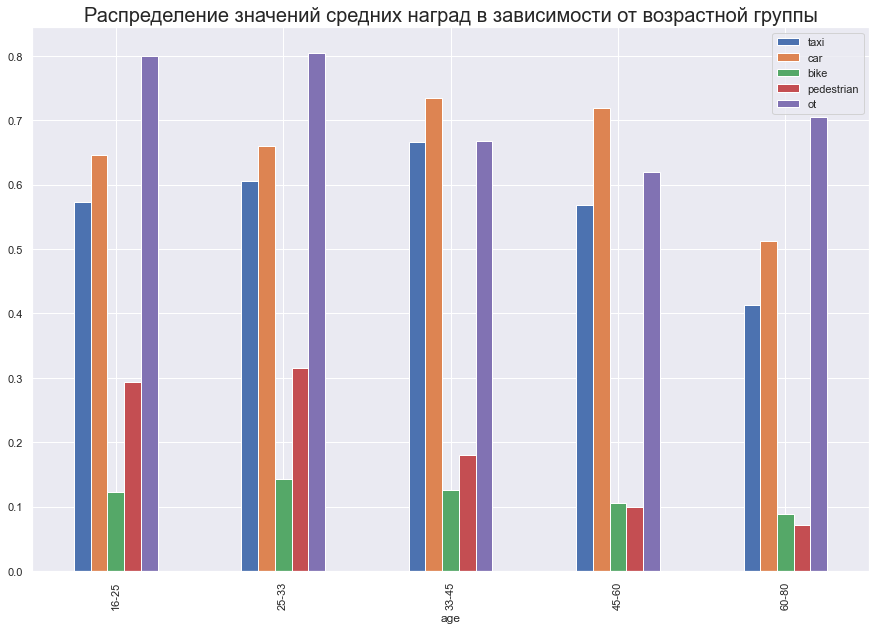

In [235]:
plt.figure(figsize=(15,10))
df.groupby('age')[targets].mean().plot(kind='bar',figsize=(15,10))
plt.title('Распределение значений средних наград в зависимости от возрастной группы', fontsize=20);

<Figure size 1080x720 with 0 Axes>

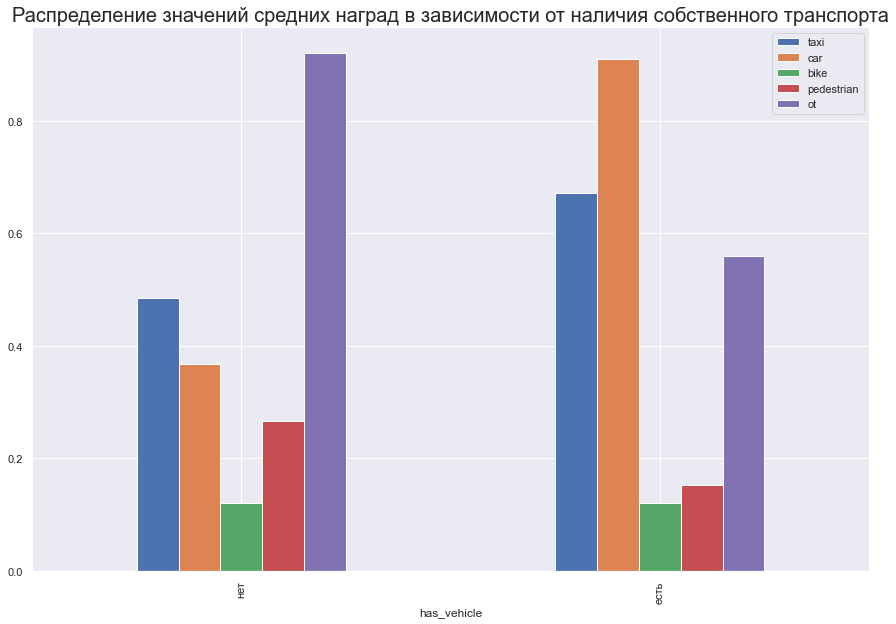

In [236]:
plt.figure(figsize=(15,10))
df_veh = df.groupby('has_vehicle')[targets].mean()
df_veh.index = df_veh.index.map({0: 'нет', 1: 'есть'})
df_veh.plot(kind='bar',   figsize=(15,10))
plt.title('Распределение значений средних наград в зависимости от наличия собственного транспорта', fontsize=20);

<Figure size 1080x720 with 0 Axes>

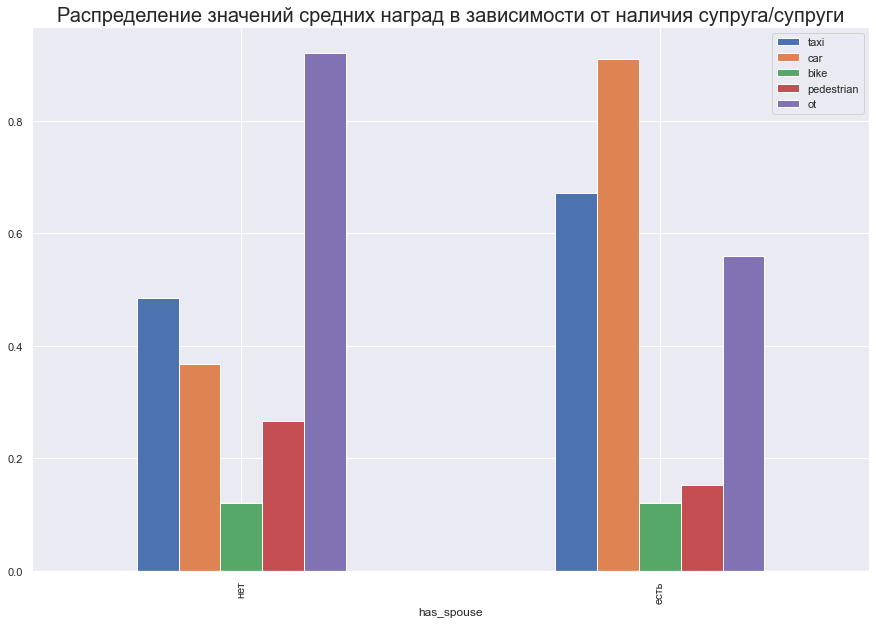

In [237]:
plt.figure(figsize=(15,10))
df_spouse = df.groupby('has_spouse')[targets].mean()
df_spouse.index = df_spouse.index.map({0: 'нет', 1: 'есть'})
df_spouse.plot(kind='bar',   figsize=(15,10))
plt.title('Распределение значений средних наград в зависимости от наличия супруга/супруги', fontsize=20);